## Preparing the environment

In [1]:
import os
import random
import numpy as np

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset, Dataset
import transformers
from accelerate import Accelerator

from tqdm import tqdm

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"

data_path = "../data"

In [2]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False

#### Setting constants

In [3]:
context_length = 128

batch_size = 128
num_workers = 8
global_batch_size = 512
accumulation_steps = global_batch_size // batch_size

learning_rate = 3e-4
betas = (0.9, 0.95)
eps = 1e-8
gradient_clipping = 1.0
weight_decay = 0.1

warmup_iters = 256

train_iters = 2048
eval_save_interval = 50
val_iters = 20

model_name = "EleutherAI/pythia-14m"
model_revision = "step0"

dataset_path = "allenai/c4"
dataset_name = "realnewslike"

## Loading dataset

In [4]:
dataset = load_dataset(dataset_path, dataset_name)
dataset = dataset.with_format("torch")

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/76 [00:00<?, ?it/s]

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, revision=model_revision)

def tokenize(data):
    outputs = tokenizer(
        data["text"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = list()
    # deleting samples shorter than context_length tokens
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
if os.path.exists(os.path.join(data_path, "train_dataset")):
    train_dataset = Dataset.load_from_disk(os.path.join(data_path, "train_dataset"))
else:
    train_dataset = dataset["train"].map(
        tokenize, batched=True, remove_columns=dataset["train"].column_names
    )
    train_dataset.save_to_disk(os.path.join(data_path, "train_dataset"))


if os.path.exists(os.path.join(data_path, "val_dataset")):
    val_dataset = Dataset.load_from_disk(os.path.join(data_path, "val_dataset"))
else:
    val_dataset = dataset["validation"].map(
        tokenize, batched=True, remove_columns=dataset["validation"].column_names
    )
    val_dataset.save_to_disk(os.path.join(data_path, "val_dataset"))

Loading dataset from disk:   0%|          | 0/58 [00:00<?, ?it/s]

In [7]:
val_dataset = val_dataset.select(range(len(val_dataset) // (batch_size * val_iters) * (batch_size * val_iters)))

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Training

### Full-rank Training

In [9]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              worker_init_fn=seed_worker,
                              generator=g)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=num_workers,
                            worker_init_fn=seed_worker,
                            generator=g,
                            drop_last=True)

In [10]:
model = transformers.AutoModelForCausalLM.from_pretrained(model_name,
                                                          revision=model_revision,
                                                          attn_implementation="flash_attention_2").to(device)

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in GPTNeoXForCausalLM is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in GPTNeoXModel is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=betas, eps=eps, weight_decay=weight_decay)

scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_iters, num_training_steps=train_iters)

In [12]:
accelerator = Accelerator(mixed_precision="fp16")

model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader
)

In [13]:
def evaluate(model, val_dataloader, val_iters):
    model.eval()
    val_losses = list()
    for step, batch in enumerate(val_dataloader):
        with torch.inference_mode():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])
            val_losses.append(outputs.loss.item())
        if step + 1 >= val_iters:
            break
    val_loss = np.mean(val_losses)
    return val_loss

In [14]:
model.train()
train_losses = dict()
val_losses = dict()
last_losses = list()
completed_steps = 0

for step, batch in tqdm(
        enumerate(train_dataloader, start=1), total=int(train_iters * accumulation_steps)
    ):
    output = model(batch["input_ids"], labels=batch["input_ids"])
    loss = output.loss
    last_losses.append(loss.item())
    loss /= accumulation_steps
    accelerator.backward(loss)
    
    if step % accumulation_steps == 0:
        accelerator.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        completed_steps += 1
    
    if step % (eval_save_interval * accumulation_steps) == 0:
        train_losses[completed_steps] = np.mean(last_losses)
        val_losses[completed_steps] = evaluate(model, val_dataloader, val_iters)
        print(
            {
                "steps": completed_steps,
                "loss/train": train_losses[completed_steps],
                "loss/val": val_losses[completed_steps],
            }
        )
        last_losses = list()
        model.train()
        accelerator.wait_for_everyone()
    
    if completed_steps >= train_iters:
        train_losses[completed_steps] = np.mean(last_losses)
        val_losses[completed_steps] = evaluate(model, val_dataloader, val_iters)
        print(
            {
                "steps": completed_steps,
                "loss/train": train_losses[completed_steps],
                "loss/val": val_losses[completed_steps],
            }
        )
        last_losses = list()
        model.train()
        accelerator.wait_for_everyone()
        break

  2%|▏         | 202/8192 [00:21<26:45,  4.98it/s]

{'steps': 50, 'loss/train': 10.70423026561737, 'loss/val': 10.263844537734986}


  5%|▍         | 402/8192 [00:38<24:31,  5.29it/s]

{'steps': 100, 'loss/train': 9.886058197021484, 'loss/val': 9.461195468902588}


  7%|▋         | 602/8192 [00:56<25:23,  4.98it/s]

{'steps': 150, 'loss/train': 8.991159381866455, 'loss/val': 8.48335428237915}


 10%|▉         | 802/8192 [01:13<23:27,  5.25it/s]

{'steps': 200, 'loss/train': 8.024157073497772, 'loss/val': 7.602251791954041}


 12%|█▏        | 1002/8192 [01:31<24:13,  4.95it/s]

{'steps': 250, 'loss/train': 7.304210848808289, 'loss/val': 7.069537329673767}


 15%|█▍        | 1202/8192 [01:49<23:20,  4.99it/s]

{'steps': 300, 'loss/train': 6.892452833652496, 'loss/val': 6.7439099788665775}


 17%|█▋        | 1402/8192 [02:07<22:35,  5.01it/s]

{'steps': 350, 'loss/train': 6.62495308637619, 'loss/val': 6.51456880569458}


 20%|█▉        | 1602/8192 [02:25<22:01,  4.99it/s]

{'steps': 400, 'loss/train': 6.431832149028778, 'loss/val': 6.347008323669433}


 22%|██▏       | 1802/8192 [02:44<21:28,  4.96it/s]

{'steps': 450, 'loss/train': 6.306636655330658, 'loss/val': 6.261314916610718}


 24%|██▍       | 2002/8192 [03:02<20:43,  4.98it/s]

{'steps': 500, 'loss/train': 6.200000398159027, 'loss/val': 6.1880425930023195}


 27%|██▋       | 2202/8192 [03:20<20:12,  4.94it/s]

{'steps': 550, 'loss/train': 6.1225613856315615, 'loss/val': 6.078747057914734}


 29%|██▉       | 2402/8192 [03:37<18:18,  5.27it/s]

{'steps': 600, 'loss/train': 6.051744701862336, 'loss/val': 6.015890288352966}


 32%|███▏      | 2602/8192 [03:55<18:22,  5.07it/s]

{'steps': 650, 'loss/train': 5.986029441356659, 'loss/val': 5.9856305599212645}


 34%|███▍      | 2802/8192 [04:13<18:05,  4.97it/s]

{'steps': 700, 'loss/train': 5.939523341655732, 'loss/val': 5.917216348648071}


 37%|███▋      | 3002/8192 [04:30<17:07,  5.05it/s]

{'steps': 750, 'loss/train': 5.889523301124573, 'loss/val': 5.882772541046142}


 39%|███▉      | 3202/8192 [04:48<16:57,  4.91it/s]

{'steps': 800, 'loss/train': 5.857176492214203, 'loss/val': 5.827268719673157}


 42%|████▏     | 3402/8192 [05:06<15:42,  5.08it/s]

{'steps': 850, 'loss/train': 5.812712953090668, 'loss/val': 5.806484699249268}


 44%|████▍     | 3602/8192 [05:24<15:35,  4.90it/s]

{'steps': 900, 'loss/train': 5.775313105583191, 'loss/val': 5.786610794067383}


 46%|████▋     | 3802/8192 [05:42<14:33,  5.02it/s]

{'steps': 950, 'loss/train': 5.750308051109314, 'loss/val': 5.752028393745422}


 49%|████▉     | 4002/8192 [06:00<14:39,  4.76it/s]

{'steps': 1000, 'loss/train': 5.720970706939697, 'loss/val': 5.713950109481812}


 51%|█████▏    | 4202/8192 [06:18<13:51,  4.80it/s]

{'steps': 1050, 'loss/train': 5.699434056282043, 'loss/val': 5.710944175720215}


 54%|█████▎    | 4402/8192 [06:36<12:52,  4.90it/s]

{'steps': 1100, 'loss/train': 5.671202223300934, 'loss/val': 5.688053369522095}


 56%|█████▌    | 4602/8192 [06:55<12:12,  4.90it/s]

{'steps': 1150, 'loss/train': 5.645548675060272, 'loss/val': 5.650246429443359}


 59%|█████▊    | 4802/8192 [07:13<11:27,  4.93it/s]

{'steps': 1200, 'loss/train': 5.6343697381019595, 'loss/val': 5.65653429031372}


 61%|██████    | 5002/8192 [07:31<10:52,  4.89it/s]

{'steps': 1250, 'loss/train': 5.614440383911133, 'loss/val': 5.625654411315918}


 64%|██████▎   | 5202/8192 [07:49<09:41,  5.14it/s]

{'steps': 1300, 'loss/train': 5.601946432590484, 'loss/val': 5.581270408630371}


 66%|██████▌   | 5402/8192 [08:06<09:22,  4.96it/s]

{'steps': 1350, 'loss/train': 5.578948378562927, 'loss/val': 5.5674748659133915}


 68%|██████▊   | 5602/8192 [08:24<08:44,  4.94it/s]

{'steps': 1400, 'loss/train': 5.570311195850373, 'loss/val': 5.585686469078064}


 71%|███████   | 5802/8192 [08:42<08:08,  4.89it/s]

{'steps': 1450, 'loss/train': 5.568822829723358, 'loss/val': 5.581095504760742}


 73%|███████▎  | 6002/8192 [09:00<07:19,  4.98it/s]

{'steps': 1500, 'loss/train': 5.5516503405570985, 'loss/val': 5.57080991268158}


 76%|███████▌  | 6202/8192 [09:18<06:53,  4.82it/s]

{'steps': 1550, 'loss/train': 5.547891736030579, 'loss/val': 5.5497111797332765}


 78%|███████▊  | 6402/8192 [09:37<06:05,  4.90it/s]

{'steps': 1600, 'loss/train': 5.53899475812912, 'loss/val': 5.53986976146698}


 81%|████████  | 6602/8192 [09:55<05:16,  5.02it/s]

{'steps': 1650, 'loss/train': 5.5330888724327085, 'loss/val': 5.550659918785096}


 83%|████████▎ | 6802/8192 [10:12<04:36,  5.03it/s]

{'steps': 1700, 'loss/train': 5.531258931159973, 'loss/val': 5.537548232078552}


 85%|████████▌ | 7002/8192 [10:30<04:04,  4.86it/s]

{'steps': 1750, 'loss/train': 5.521949307918549, 'loss/val': 5.519060683250427}


 88%|████████▊ | 7202/8192 [10:48<03:21,  4.91it/s]

{'steps': 1800, 'loss/train': 5.525350918769837, 'loss/val': 5.5284184217453}


 90%|█████████ | 7402/8192 [11:06<02:39,  4.96it/s]

{'steps': 1850, 'loss/train': 5.51183913230896, 'loss/val': 5.521555948257446}


 93%|█████████▎| 7602/8192 [11:25<02:01,  4.84it/s]

{'steps': 1900, 'loss/train': 5.520656044483185, 'loss/val': 5.519441986083985}


 95%|█████████▌| 7802/8192 [11:43<01:19,  4.90it/s]

{'steps': 1950, 'loss/train': 5.520800156593323, 'loss/val': 5.53406593799591}


 98%|█████████▊| 8002/8192 [12:01<00:38,  4.90it/s]

{'steps': 2000, 'loss/train': 5.514129006862641, 'loss/val': 5.524821877479553}


100%|█████████▉| 8191/8192 [12:18<00:00, 11.09it/s]

{'steps': 2048, 'loss/train': 5.514789372682571, 'loss/val': 5.537773752212525}


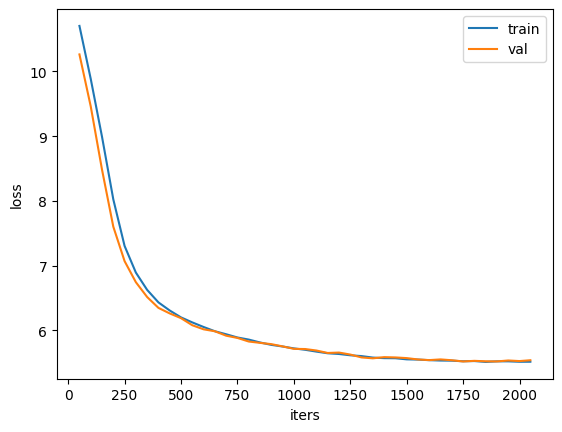

In [15]:
plt.plot(*zip(*train_losses.items()))
plt.plot(*zip(*val_losses.items()))
plt.legend(['train', 'val'], loc='upper right')
plt.ylabel('loss')
plt.xlabel('iters')
plt.show()